# Temporal downscaling of daily climate projections
### Application to daily time series of wind power capacity factor 


In this notebook we demonstrate a simple approach to increase the temporal resolution of climate projection from one day to one hour. The method consists in a search of sequences of daily values in reanalysis that are similar to the climate projection. The length of the sequences is limited to a few days (typically 7 days) to ensure that analogous situation can be found in the reanalysis. Once an analog daily sequences is found, the hourly reanalysis are used to populate the temporally downscaled climate projection.

The search of the analogs is made for each day independantly. The analogy is evaluated by estimating the difference between the daily climate projection sequence and the daily reanalysis sequence. We considered the quadratic difference weighted by a Gaussian Kernel centered on the current day. To ensure the plausibility of the method, the analog search is limited to exclude situation from a totally different season or time of the day (for wind only). 

The search being made on a daily basis, there is a risk to obtain jumps between days. This risk is mitigated by two means: 
 - using sequences for the search ensures that the choice of a day take into consideration the previous and following days avoiding by construction strong differences
 - not only the current day is used for the building the downscaled time series but all days of the sequence (i.e. the 7 days), each day being weighted using the kernel (the central day is weighted by far the most and the preceeding and subsequent day less)

The choice of the Kernel width is therefore a very important hyperparameter of the method. A too large kernel will result in a long sequence which will be difficult to find. In addition, it will result in an oversmoothing of the result because the difference in weight between the current, preceeding and subsequent day will be too similar. A too small kernel will not consider the dynamic of the signal and will ultimately result in jumps between days (see previous paragraph).

The current example is built upon regionally averaged wind power capacity factors calculated in the clim2power project. We recomment to use this approach for geographically averaged values because their lower variability will facilitate the performance algorithm. It is however possible to apply it at grid cell level but it should then be kept in mind that the spatial coherence is not ensured so that a later aggregation may yields irrealistic results.

It is important to note that - while similar in principle - the implementation detail of the method is different for wind and solar energy. The reason is that the daily climate projection values are instantaneous values with a sampling period of 24 hours while solar data are daily averages. As a result, two separate notebooks have been made for the two energy sources. The present notebook deals with wind energy.

The limitations of the algorithm are the following:
 - the output of the algorithm doesn't ensure a spatial coherence: it should thus be applied at the end of the chain
 - there is no coherence among the difference energy sources: there is no guarantee that the downscaled wind power capacity factor is coherent with a downscaled solar PV capacity factor.
 - the output of the algorithm should be considered as scenario or synthetic data: it is a possible time series that has the desired properties at daily scales but there are many other potential time series.
 - if climate projection includes sequences that are not present in the past, the algorithm will fail
 
 The data used in this notebook can be downloaded on the following link:
 https://cloud.minesparis.psl.eu/index.php/s/WjqM1HqQRuuWdXU


In [1]:
import glob 
import os
import numpy as np
import netCDF4 as nc
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### 1. Definition of the parameters of the algorithm

First, we define the parameters of the downscaling algorithm. The most important parameter is the standard deviation of the Gaussian kernel used for the analog search. We empirically select a value of 1-3 day (SKernAnalogy=1-3) which yields satistying results. The following parameters are the tolerance on the hour of the day and day of year that will limit the domain of search of the analogs (dHours and dDOY).

In [2]:
SKernAnalogy=3
dHours=3
dDOY=60

Using SKernWeigth, we define length of the sequence used for the seach (X0) and the Kernel (W0). The sequence X0 is defined as ranging from -3 times the standard deviation to 3 times the standard deviation.

In [3]:
X0=np.arange(-3*SKernAnalogy,3*SKernAnalogy+1)
W0=np.exp(-0.5*(X0/SKernAnalogy)**2)

### 2. Definition of the input data with a daily resolution

 Definition of the data used for the downscaling and the region to be processed (to be adjusted to the actual location of the archives):

In [4]:
Data2process=r"C:\Users\y-m.saint-drenan\ownCloud\C2P_Data4TemporalDowscaling/ClimateProjection_Aggregated_WindCF/windcf_C85.csv"


Definition of the region where we want to conduct the temporal downscaling:

In [5]:
RegionID='PT0801'

Reading and plotting the data we want to downscale:

In [6]:
%%time
df_InputDaily=pd.read_csv(Data2process,
               parse_dates={'time':['year','month','day','hour','minute','second']}, 
               date_parser=lambda x: dt.datetime.strptime(x, '%Y %m %d %H %M %S'),
               usecols=['year','month','day','hour','minute','second',RegionID],
              index_col='time')
df_InputDaily.head()

CPU times: total: 2.61 s
Wall time: 2.61 s


,PT0801
time,
2016-01-01 12:00:00,0.214380
2016-01-02 12:00:00,0.579080
2016-01-03 12:00:00,0.168630
2016-01-04 12:00:00,0.000000
2016-01-05 12:00:00,0.070588


<AxesSubplot:title={'center':'input data with a daily time resolution'}, xlabel='time'>

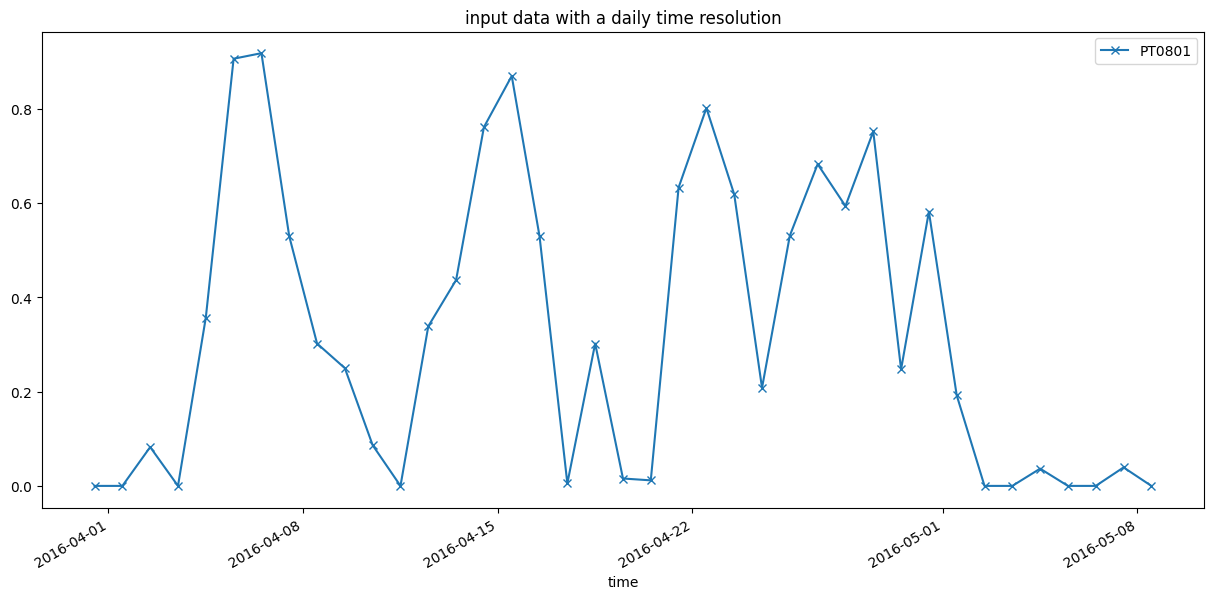

In [7]:
df_InputDaily.iloc[range(90,129)].plot(marker='x',title='input data with a daily time resolution',figsize=[15,7])

## 3. Preparation of the reference data with a hourly time resolution (REA6)

In this second step we read the regionally-averaged wind power capacity factors calculated with REA6. The data are saved on a monthly basis where each column corresponds to a region.

In [8]:
%%time
path=r'C:\Users\y-m.saint-drenan\ownCloud\C2P_Data4TemporalDowscaling/Reanalysis_Aggregated_WindCF'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file=(pd.read_csv(f,
              parse_dates={'time':['year','month','day','hour','minute','second']}, 
               date_parser=lambda x: dt.datetime.strptime(x, '%Y %m %d %H %M %S'),
               usecols=['year','month','day','hour','minute','second',RegionID],
              index_col='time') for f in all_files)

df_reference_hourly=pd.concat(df_from_each_file)

df_reference_hourly.head()

CPU times: total: 32.5 s
Wall time: 36.6 s


,PT0801
time,
1995-01-01 00:00:00,0.85229
1995-01-01 01:00:00,0.85229
1995-01-01 02:00:00,0.89412
1995-01-01 03:00:00,0.91111
1995-01-01 04:00:00,0.89412


Using the hourly reanalysis data we prepare a dictionnary containing daily data that will be used later for search the days that match the best with the sequences of daily climate projection. Since the wind power capacity factor is an instantaneous value sampled with a 24 hour rate we pick one reanalysis value each 24 hours. The array RefDataVal has a as much row as time steps available in the reanalysis and as much column as elements in X0 (i.e. the number of days considered for the analog sequence search):

In [9]:
%%time

RefDataVal=0*np.ones([len(df_reference_hourly[RegionID]),len(X0)])
for ii in np.arange(0,len(X0)):
    RefDataVal[:,ii]=np.roll(df_reference_hourly[RegionID].values,-X0[ii]*24)
RefData={'time':df_reference_hourly.index[len(X0):-len(X0)],'val':RefDataVal[len(X0):-len(X0),:]}
nref=len(RefData['time'])
print(RefData['val'].shape)

(184042, 19)
CPU times: total: 93.8 ms
Wall time: 99 ms


## 4. Identification of the analogs

The search of the analog is made on a daily basis and is made of NB main steps described below:
  - step 1: calculation of the difference between the potential candidates in the reanalysis and the sequence of daily values around the current day (TimeStep)
  - step 2: increase of the analog metric for days that doesn't fulfill the condition of the analog search (time of the day and day of year)
  - step 3: selection of the day where the reanalysis sequence is the most similar to the sequence of daily climate projections
  - step 4: selection of the hourly values corresponding to the best analog
  - step 5: calculation of the weights
  - step 6: incrementation of the current results to the final dataframe



In [10]:
%%time

TimeRef=pd.date_range(start=min(df_InputDaily.index), end=max(df_InputDaily.index), freq='1H')
df_interpolated=pd.DataFrame({'Time':TimeRef,'SumVal':0*np.ones(TimeRef.shape),'SumWeigths':0*np.ones(TimeRef.shape),'Val':0*np.ones(TimeRef.shape)})

for ii,TimeStep in enumerate(df_InputDaily.index[:200]):
    
    #print(ii,TimeStep)
    
    if (ii>len(X0)/2+1) & (ii<(len(df_InputDaily.index)-len(X0)/2-1)):
        
        # step 1 : Calculate the performance of each day contained in the reference dataset
        X=ii+X0               # list of indexes considered for evaluating the current step
        idxX=(X>=0) & (X<len(df_InputDaily.index))
        diffVal=np.tile(df_InputDaily[RegionID][X[idxX]].values,(nref,1))-RefData['val'][:,idxX]
        Delta=np.sum((diffVal**2)*np.tile(W0[idxX],(nref,1)),axis=1)

        # step 2 :  Exclude time step that don't satisfy the condition on TOD and DOY
        diffDOY=(RefData['time'].day_of_year - TimeStep.day_of_year).values
        diffDOY[diffDOY<-365/2]+=365
        diffDOY[diffDOY>int(365/2)]+=-365
        Delta[np.abs(diffDOY)>dDOY]=999999 
        diffTOD=(RefData['time'].hour - TimeStep.hour).values
        diffTOD[diffTOD<-12]+=24
        diffTOD[diffTOD>12]+=-24
        Delta[np.abs(diffTOD)>dHours]=999999                              
        
        # step 3 :  search for the index of the best analog for the current time step
        idxDailyAnalog=np.argsort(Delta)[0]
        
        # step 4: search for the hourly value corresponding to the best analog
        TimeStart=RefData['time'][idxDailyAnalog]+np.timedelta64(np.min(24*X0[idxX]),'h')
        TimeEnd=RefData['time'][idxDailyAnalog]+np.timedelta64(np.max(24*X0[idxX]),'h')
        idxHourlyAnalog=(df_reference_hourly.index>TimeStart) & (df_reference_hourly.index<TimeEnd)
            
        deltaTime=np.datetime64(RefData['time'][idxDailyAnalog])-np.datetime64(TimeStep)
        tTime=df_reference_hourly.index[idxHourlyAnalog].values-deltaTime
        tVal=df_reference_hourly[RegionID][idxHourlyAnalog]

        # step 5: calculation of the weights
        dt=(tTime-np.tile(np.datetime64(TimeStep),tTime.shape))/np.timedelta64(60*24,'m')
        tWeight=np.exp(-0.5*(dt/SKernAnalogy)**2) 

        # step 6: incrementation of the current results to the final dataframe
        xy, ia, ib = np.intersect1d(df_interpolated['Time'], tTime, return_indices=True)
        df_interpolated.loc[ia,'SumVal'] += tVal[ib].values*tWeight[ib]
        df_interpolated.loc[ia,'SumWeigths'] += tWeight[ib]

# calculation of the final value
df_interpolated['Val']=df_interpolated['SumVal']/df_interpolated['SumWeigths']


CPU times: total: 1min 7s
Wall time: 1min 8s


## 5. Plot of the results
The input time series of climate projection with a daily resolution are represented in red. The downscaled data with a hourly time resolution are represented in blue.

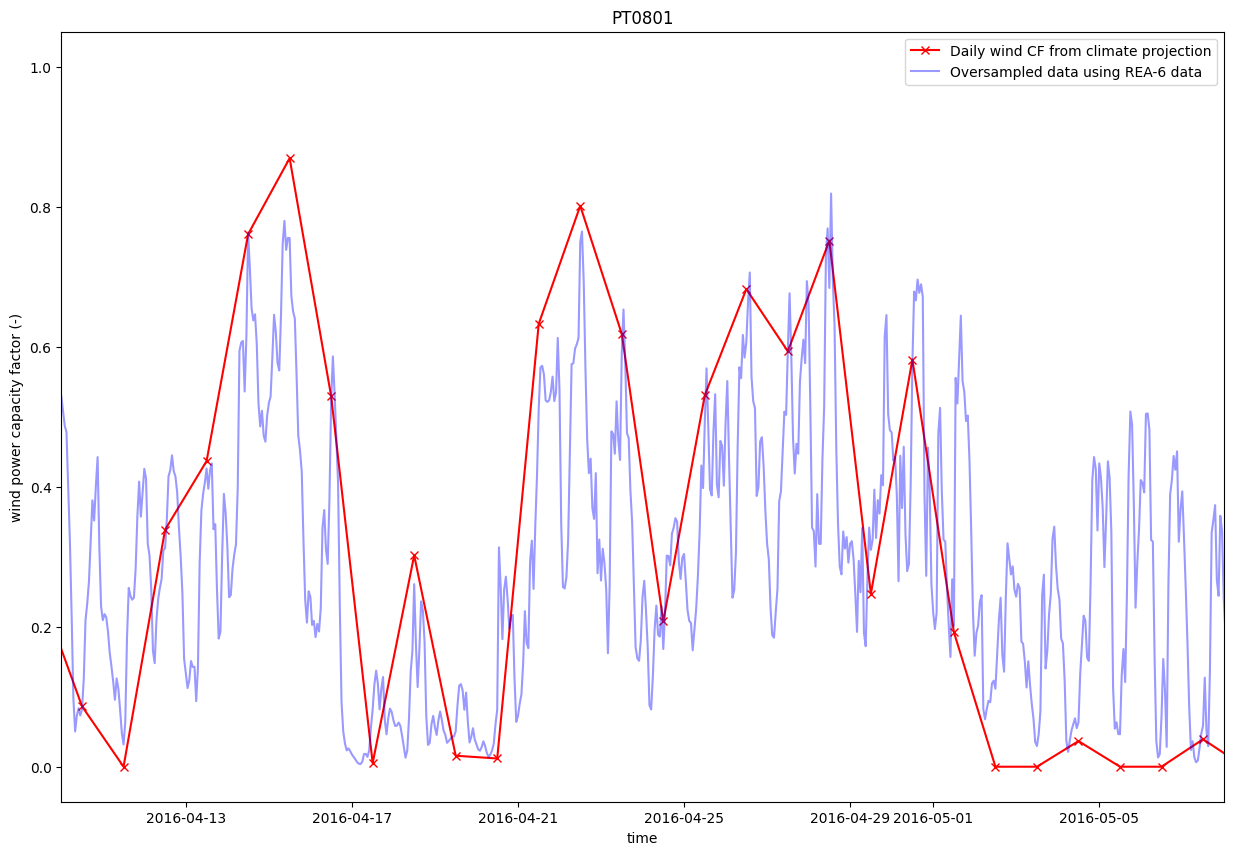

In [11]:
df_interpolated['Val']=df_interpolated['SumVal']/df_interpolated['SumWeigths']

plt.subplots(figsize=(15,10))
plt.plot(df_InputDaily.index,df_InputDaily[RegionID].values,marker='x',color='r',label='Daily wind CF from climate projection')
plt.plot(df_interpolated['Time'],df_interpolated['Val'],color='b',label='Oversampled data using REA-6 data',alpha=0.4)
plt.xlim([pd.to_datetime('2016-04-10'),pd.to_datetime('2016-05-08')])
plt.title(RegionID)
plt.ylabel('wind power capacity factor (-)')
plt.xlabel('time')
plt.legend()